In [753]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

In [754]:
mt5.initialize()

True

In [755]:
start_date = datetime(2024, 1, 15)
end_date = datetime(2025, 10, 31)
timeframe = mt5.TIMEFRAME_H1

asset = "EURGBP"

price_df = mt5.copy_rates_range(asset, timeframe, start_date, end_date)
assert price_df.shape[0] > 0
price_df = pd.DataFrame(price_df)

In [756]:
price_df.loc[:, "time_dt"] = pd.to_datetime(price_df.time, unit="s")
price_df.loc[:, "week"] = price_df.loc[:, "time_dt"].apply(lambda date: date.isocalendar()[1])

In [757]:
def get_prev_week_high(date, df, lag=1):
    assert lag > 0

    df_copy = df.copy()
    df_copy = df_copy.set_index("time_dt")
    week = df_copy.loc[date, "week"]
    lagged_week = week - lag
    lagged_df = df_copy.loc[df_copy.week == lagged_week]

    if lagged_df.empty:
        return np.nan
    else:
        return np.log(df_copy.loc[date, "close"]) - np.log(lagged_df.high.max())

def get_prev_week_low(date, df, lag=1):
    assert lag > 0

    df_copy = df.copy()
    df_copy = df_copy.set_index("time_dt")
    week = df_copy.loc[date, "week"]
    lagged_week = week - lag
    lagged_df = df_copy.loc[df_copy.week == lagged_week]

    if lagged_df.empty:
        return np.nan
    else:
        return np.log(df_copy.loc[date, "close"]) - np.log(lagged_df.low.min())

## Lagged Weekly Highs/Lows

In [758]:
lag = 1
lag_high_1_week = price_df.loc[:, "time_dt"].apply(lambda date: get_prev_week_high(date, price_df, lag=lag))
lag_low_1_week = price_df.loc[:, "time_dt"].apply(lambda date: get_prev_week_low(date, price_df, lag=lag))

lag = 2
lag_high_2_week = price_df.loc[:, "time_dt"].apply(lambda date: get_prev_week_high(date, price_df, lag=lag))
lag_low_2_week = price_df.loc[:, "time_dt"].apply(lambda date: get_prev_week_low(date, price_df, lag=lag))

close = price_df.close

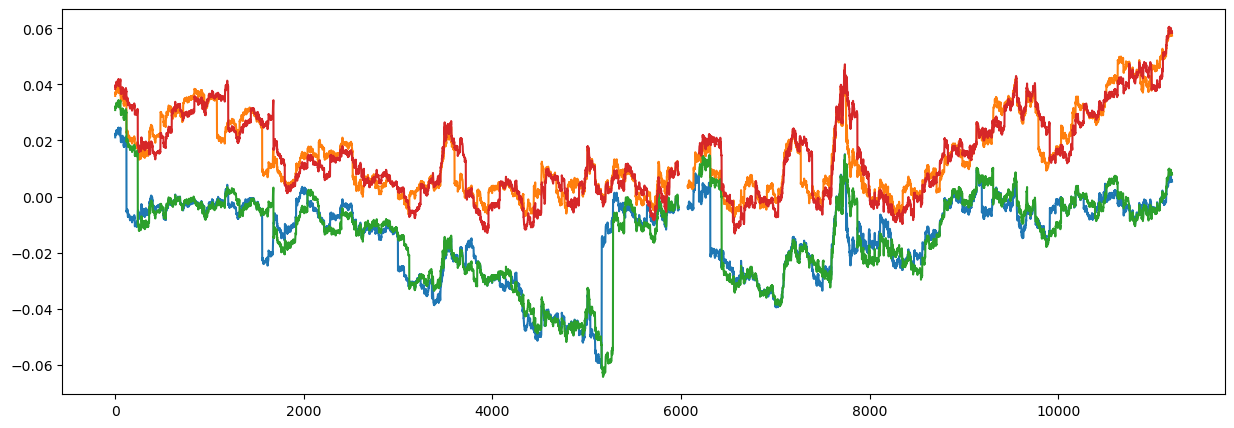

In [759]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

# ax.plot(price_df.index, close)
ax.plot(price_df.index, lag_high_1_week)
ax.plot(price_df.index, lag_low_1_week)
ax.plot(price_df.index, lag_high_2_week)
ax.plot(price_df.index, lag_low_2_week)

### Order Blocks

In [695]:
price_df = price_df.sort_index()

o, h, l, c = (price_df['open'], price_df['high'], price_df['low'], price_df['close'])
o_1, h_1, l_1, c_1 = o.shift(1), h.shift(1), l.shift(1), c.shift(1)

# Your logic applied at t using (t) and (t-1)
bull_order_block = (c > o) & (o_1 > c_1) & (h > h_1)
bear_order_block = (c < o) & (o_1 > c_1) & (l < l_1)

In [761]:
indicators = pd.concat([lag_high_1_week,
                        lag_low_1_week,
                        lag_high_2_week,
                        lag_low_2_week,
                        bull_order_block,
                        bear_order_block,
                        price_df["time_dt"].dt.hour], axis=1)

indicators.columns = ["lag_high_1_week",
                      "lag_low_1_week",
                      "lag_high_2_week",
                      "lag_low_2_week",
                      "bull_order_block",
                      "bear_order_block",
                      "hour"]

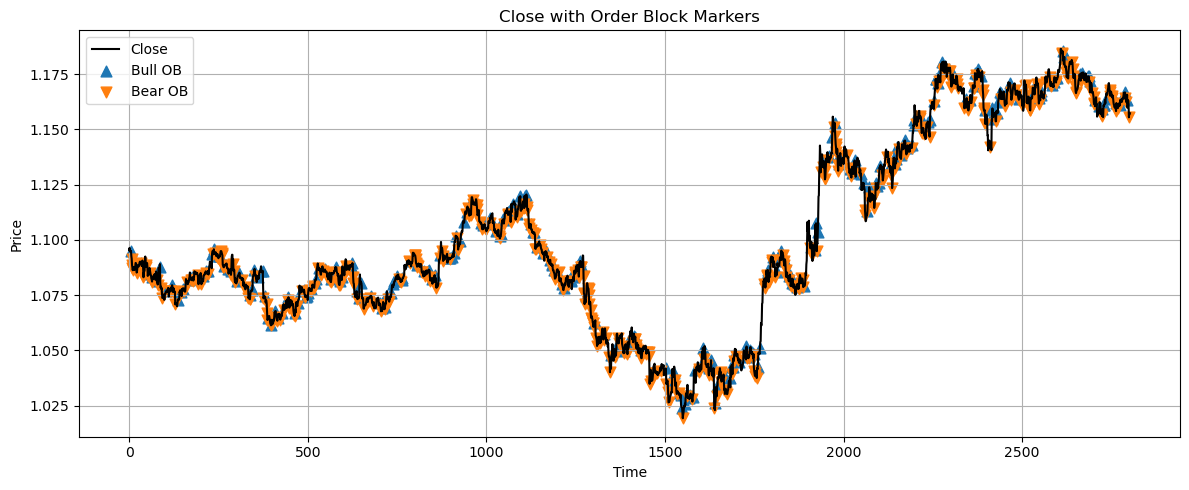

In [576]:
# Make sure flags are boolean without NaNs
flags = indicators[['bull_order_block', 'bear_order_block']].fillna(False)
bull = flags['bull_order_block']
bear = flags['bear_order_block']

# Indexes where signals occur
bull_idx = price_df.index[bull]
bear_idx = price_df.index[bear]

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(price_df.index, price_df['close'], label='Close', color='black')

# Scatter markers at the close price on signal bars
ax.scatter(bull_idx, price_df.loc[bull_idx, 'close'], marker='^', s=60, label='Bull OB')
ax.scatter(bear_idx, price_df.loc[bear_idx, 'close'], marker='v', s=60, label='Bear OB')

ax.set_title('Close with Order Block Markers')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend(loc='best')
ax.grid(True)
plt.tight_layout()
plt.show()


## Spread with correlated assets

In [762]:
corr_asset = "EURUSD"
price_corr_df = mt5.copy_rates_range(corr_asset, timeframe, start_date, end_date)

assert price_df.shape[0] > 0
price_corr_df = pd.DataFrame(price_corr_df)

In [763]:
spread = price_df.close.apply(np.log) - price_corr_df.close.apply(np.log)

In [764]:
high_factor, medium_factor, short_factor = 15, 50, 200

spread_high_demeaned = spread.rolling(high_factor).apply(lambda x: (x[-1]-np.mean(x))/np.std(x), raw=True).rename("spread_high_demeaned")
spread_medium_demeaned = spread.rolling(medium_factor).apply(lambda x: (x[-1]-np.mean(x))/np.std(x), raw=True).rename("spread_medium_demeaned")
spread_short_demeaned = spread.rolling(short_factor).apply(lambda x: (x[-1]-np.mean(x))/np.std(x), raw=True).rename("spread_short_demeaned")

<Axes: >

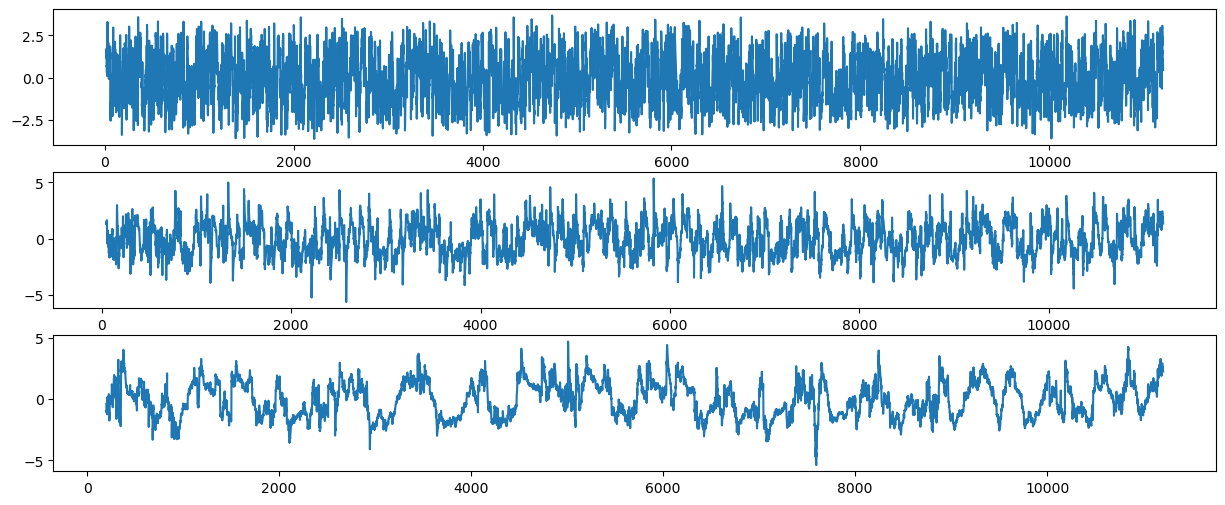

In [708]:
fig, ax = plt.subplots(nrows=3, figsize=(15, 6))

spread_high_demeaned.plot(ax=ax[0], label="Spread High Demeaned")
spread_medium_demeaned.plot(ax=ax[1], label="Spread Medium Demeaned")
spread_short_demeaned.plot(ax=ax[2], label="Spread Short Demeaned")

In [765]:
indicators = pd.concat([indicators,
                        spread_high_demeaned,
                        spread_medium_demeaned,
                        spread_short_demeaned], axis=1)

In [766]:
from datetime import time
mask = price_df['time_dt'].dt.time < time(21, 0)
filtered_price_df = price_df[mask]

In [767]:
indicators

,lag_high_1_week,lag_low_1_week,lag_high_2_week,lag_low_2_week,bull_order_block,bear_order_block,hour,spread_high_demeaned,spread_medium_demeaned,spread_short_demeaned
0,0.021128,0.035892,0.030858,0.038382,False,False,0,NaN,NaN,NaN
1,0.022001,0.036765,0.031731,0.039255,False,False,1,NaN,NaN,NaN
2,0.022536,0.037300,0.032267,0.039790,False,False,2,NaN,NaN,NaN
3,0.022397,0.037161,0.032127,0.039651,False,False,3,NaN,NaN,NaN
4,0.021792,0.036556,0.031522,0.039046,False,True,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
11203,0.005325,0.057384,0.007820,0.058384,False,True,20,1.021850,1.612098,2.440369
11204,0.005882,0.057941,0.008377,0.058941,True,False,21,1.081153,1.688535,2.477911
11205,0.005780,0.057839,0.008275,0.058839,False,False,22,1.065599,1.688368,2.475358
11206,0.005450,0.057509,0.007945,0.058509,False,True,23,0.536875,1.378515,2.286948


### Target

In [768]:
def retrieve_forward_nyc_close_return(date, df):
    df_copy = df.copy()
    df_copy = df_copy.set_index("time_dt")
    # Retrieve NYC Close timestamp
    nyc_close_ts = date.replace(hour=21, minute=0)
    if nyc_close_ts not in df_copy.index:
        return np.nan
    return np.log(df_copy.loc[nyc_close_ts, "close"]) - np.log(df_copy.loc[date, "close"])

In [769]:
nyc_close_fwd_return = filtered_price_df.loc[:, "time_dt"].apply(lambda date: retrieve_forward_nyc_close_return(date, price_df))

Text(0.5, 1.0, 'NYC Close Forward Return')

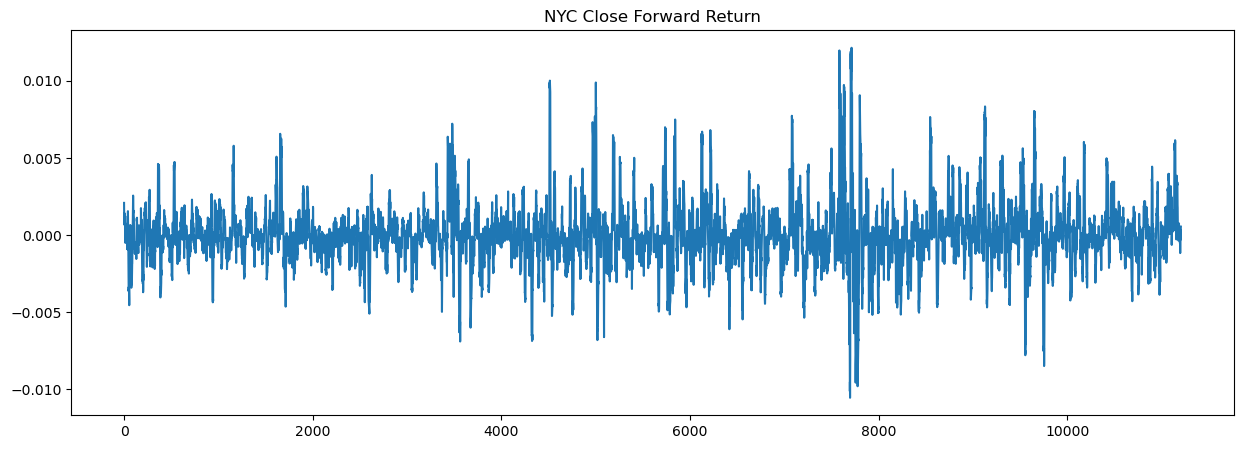

In [770]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

nyc_close_fwd_return.plot(ax=ax)
ax.set_title("NYC Close Forward Return")

<Axes: >

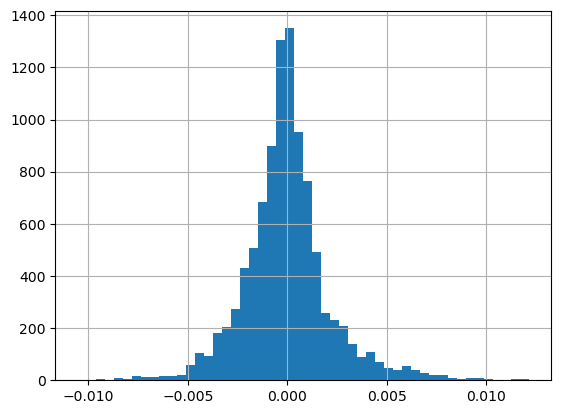

In [771]:
nyc_close_fwd_return.hist(bins=50)

In [772]:
indicators.columns

Index(['lag_high_1_week', 'lag_low_1_week', 'lag_high_2_week',
       'lag_low_2_week', 'bull_order_block', 'bear_order_block', 'hour',
       'spread_high_demeaned', 'spread_medium_demeaned',
       'spread_short_demeaned'],
      dtype='object')

In [773]:
subsampled_indicators = indicators[mask][indicators["bull_order_block"] | indicators["bear_order_block"]]

In [774]:
subsampled_indicators = subsampled_indicators.dropna()

In [775]:
subsampled_fwd_return = nyc_close_fwd_return.loc[subsampled_indicators.index]

## OLS Model to predict the return the end of the NYC Session

In [776]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [777]:
X_train, X_test, y_train, y_test = train_test_split(subsampled_indicators.values.astype(float),
                                                    subsampled_fwd_return.values,
                                                    shuffle=False,)

In [778]:
model = sm.OLS(y_train, X_train)
model = model.fit()

In [779]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.396
Date:                Sun, 02 Nov 2025   Prob (F-statistic):           1.03e-05
Time:                        20:49:13   Log-Likelihood:                 10595.
No. Observations:                2227   AIC:                        -2.117e+04
Df Residuals:                    2217   BIC:                        -2.111e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0149      0.007      2.248      0.025       0.002       0.028
x2             0.0191      0.009      2.161      0.031       0.002       0.036
x3            -0.0249      0.007     -3.696      0.000      -0.038      -0.012
x4            -0.0130      0.008     -1.637      0.102      -0.029       0.003
x5            -0.0007      0.000     -4.178      0.000      -0.001      -0.000
x6            -0.0005      0.000     -3.075      0.002      -0.001      -0.000
x7          1.072e-05   7.82e-06      1.371      0.171   -4.62e-06     2.6e-05
x8          3.997e-05   4.35e-05      0.918      0.358   -4.54e-05       0.000
x9            -0.0001   5.99e-05     -2.283      0.023      -0.000   -1.93e-05
x10            0.0001   4.63e-05      2.707      0.007    3.45e-05       0.000
==============================================================================
Omnibus:                      301.454   Durbin-Watson:                   0.499
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1358.703
Skew:                           0.575   Prob(JB):                    9.15e-296
Kurtosis:                       6.649   Cond. No.                     3.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

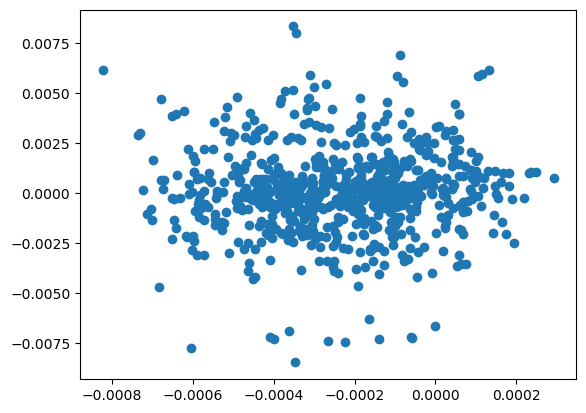

In [722]:
plt.scatter(model.predict(X_test), y_test)

In [795]:
## Decision Tree
from sklearn import tree
from sklearn.metrics import accuracy_score, r2_score
from tqdm.notebook import tqdm

r2_scores = pd.Series()
accuracy_scores = pd.Series()

for max_depth in tqdm(range(3, 6)):
    clf = tree.DecisionTreeRegressor(max_depth=max_depth)
    clf = clf.fit(X_train, y_train)

    r2_scores[max_depth] = r2_score(y_test[:-1], clf.predict(X_test[:-1, :]))
    accuracy_scores[max_depth] = accuracy_score(y_test > 0, clf.predict(X_test) > 0)

  0%|          | 0/3 [00:00<?, ?it/s]

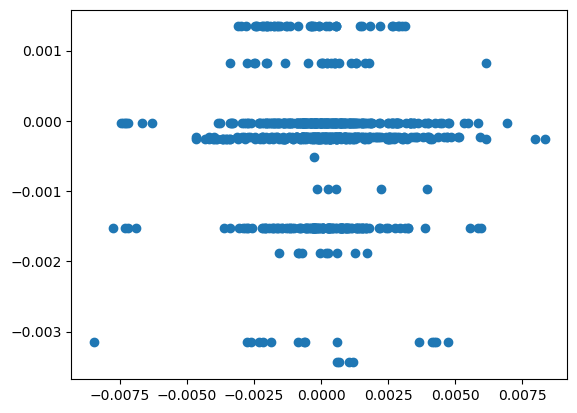

In [796]:
plt.scatter(y_test, clf.predict(X_test))

In [747]:

feat_names = list(getattr(clf, "feature_names_in_", None) or subsampled_indicators.columns)

# 1) Print the tree rules
print(tree.export_text(clf, feature_names=feat_names, decimals=3))

|--- lag_high_2_week <= -0.003
|   |--- lag_low_2_week <= 0.021
|   |   |--- lag_low_2_week <= -0.010
|   |   |   |--- spread_high_demeaned <= -2.391
|   |   |   |   |--- lag_low_2_week <= -0.011
|   |   |   |   |   |--- value: [0.000]
|   |   |   |   |--- lag_low_2_week >  -0.011
|   |   |   |   |   |--- value: [1.000]
|   |   |   |--- spread_high_demeaned >  -2.391
|   |   |   |   |--- spread_medium_demeaned <= 1.879
|   |   |   |   |   |--- lag_high_1_week <= -0.030
|   |   |   |   |   |   |--- value: [1.000]
|   |   |   |   |   |--- lag_high_1_week >  -0.030
|   |   |   |   |   |   |--- spread_high_demeaned <= 0.121
|   |   |   |   |   |   |   |--- value: [0.000]
|   |   |   |   |   |   |--- spread_high_demeaned >  0.121
|   |   |   |   |   |   |   |--- value: [1.000]
|   |   |   |   |--- spread_medium_demeaned >  1.879
|   |   |   |   |   |--- value: [0.000]
|   |   |--- lag_low_2_week >  -0.010
|   |   |   |--- lag_high_2_week <= -0.048
|   |   |   |   |--- lag_high_1_week <= -0.

### Conformal Prediction addition

In [782]:
from sklearn.tree import DecisionTreeRegressor
from mapie.regression import SplitConformalRegressor
from sklearn.model_selection import train_test_split

# X, y are your features/target
X_tr, X_cal, y_tr, y_cal = train_test_split(X_train, y_train, test_size=0.6, shuffle=True)
base = DecisionTreeRegressor(random_state=0, max_depth=3).fit(X_tr, y_tr)

# Split conformal on a prefit model (use calibration set)
conf = SplitConformalRegressor(estimator=base)  # absolute residual score by default
conf.conformalize(X_cal, y_cal)

# 90% marginal coverage -> alpha = 0.10
y_pred_conf = conf.predict_interval(X_test)   # y_pi[:, 0] = lower, y_pi[:, 1] = upper

In [783]:
y_pred_conf = pd.DataFrame(y_pred_conf).T

In [784]:
print(r2_score(y_test, y_pred_conf.iloc[:, 0]))
print(accuracy_score(y_test > 0, y_pred_conf.iloc[:, 0] > 0))

ValueError: Input contains NaN.

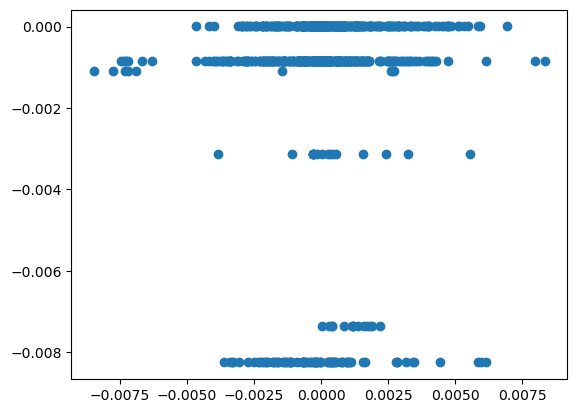

In [785]:
plt.scatter(y_test, y_pred_conf.iloc[:, 0], label="lower")

In [627]:
y_lower = y_pred_conf.loc[:, 1].apply(lambda x: x[0][0])
y_upper = y_pred_conf.loc[:, 1].apply(lambda x: x[1][0])

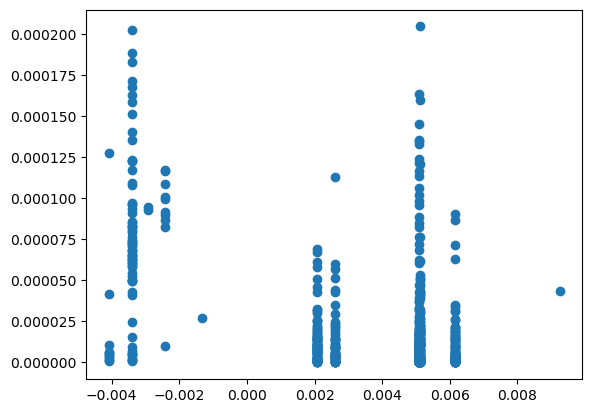

In [630]:
plt.scatter(y_upper, np.square(y_test - y_pred_conf.iloc[:, 0]), label="error")

In [628]:
y_upper - y_lower

0      0.009961
1      0.009961
2      0.009961
3      0.009961
4      0.009961
         ...   
766    0.009961
767    0.009961
768    0.009961
769    0.009961
770    0.009961
Name: 1, Length: 771, dtype: float64